### Objective:

The **main purpose** is to build a **Recommendation System** able to filter and compute similarity between items. 

In this case, a dataset of Steam Games was provided and the main goal then is to create the system from a content-based filtering approach using the Cosine Similarity Algorithm (which is a simple solution for the dot product formula from Liear Algebra).

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

## **Pre-modeling Stage**

### Exploring data

In [38]:
df = pd.read_json('./data/games.json.gz', lines=True, compression='gzip')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32133 entries, 0 to 32132
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   item_id       32133 non-null  int64 
 1   developer     32133 non-null  object
 2   app_name      32133 non-null  object
 3   genres        32133 non-null  object
 4   tags          32133 non-null  object
 5   specs         32133 non-null  object
 6   release_year  32133 non-null  object
 7   price         32133 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.0+ MB


Notice columns are objects except for the id.

In [39]:
# Copying to avoid any change on the original df
df_games = df.copy()
df_games.head()

,item_id,developer,app_name,genres,tags,specs,release_year,price
0,761140,Kotoshiro,Lost Summoner Kitty,"[Action, Casual, Indie, Simulation, Strategy]","[Strategy, Action, Indie, Casual, Simulation]",[Single-player],2018,4.99
1,643980,Secret Level SRL,Ironbound,"[Free to Play, Indie, RPG, Strategy]","[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla...",2018,Free To Play
2,670290,Poolians.com,Real Pool 3D - Poolians,"[Casual, Free to Play, Indie, Simulation, Sports]","[Free to Play, Simulation, Sports, Casual, Ind...","[Single-player, Multi-player, Online Multi-Pla...",2017,Free to Play
3,767400,彼岸领域,弹炸人2222,"[Action, Adventure, Casual]","[Action, Adventure, Casual]",[Single-player],2017,0.99
4,773570,Unknown,Log Challenge,Empty,"[Action, Indie, Casual, Sports]","[Single-player, Full controller support, HTC V...",Unknown,2.99


- How many games were released per year?
- What is the maximum number of games? and the minimum?
- How does it look?

In [40]:
# Replacing values to int
df_games['release_year'] = df_games['release_year'].replace('Unknown', np.NaN).map(lambda y: int(y), na_action='ignore')

In [41]:
# Value count for each year
years = df_games['release_year'].value_counts()

print(f'Year when the most games were released: {years.idxmax()} - {years[years.idxmax()]} games')
print(f'Year when the least games were released: {years.idxmin()} - {years[years.idxmin()]} game')


Year when the most games were released: 2017.0 - 9560 games
Year when the least games were released: 1986.0 - 1 game


(0.0, 1000.0)

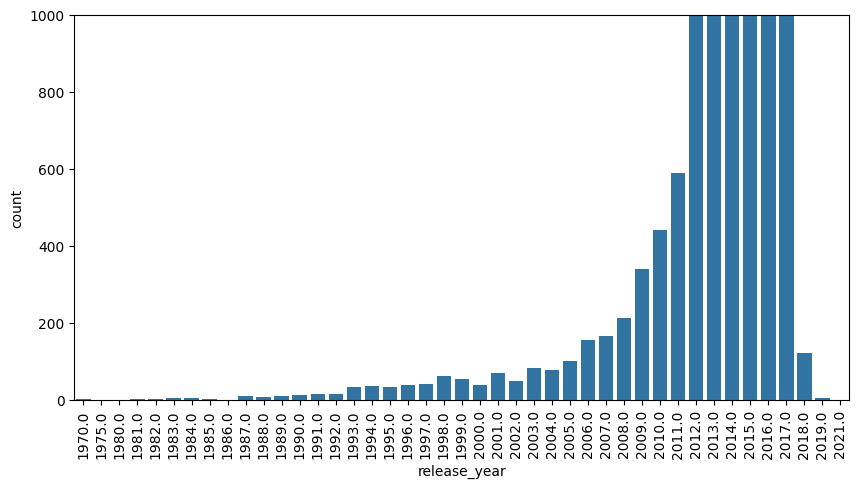

In [42]:
#Plotting
ax = sns.countplot(df_games, x='release_year')
ax.figure.set_size_inches(10,5)
ax.tick_params(axis='x', rotation=90) # Rotate x ticks
ax.set_ylim(top=1000) # Limitting y axis to 4000

Number of games released in a year increases drastically since early 2000's.

What about genres and tags?

In [43]:
df_games[['genres', 'tags']]

,genres,tags
0,"[Action, Casual, Indie, Simulation, Strategy]","[Strategy, Action, Indie, Casual, Simulation]"
1,"[Free to Play, Indie, RPG, Strategy]","[Free to Play, Strategy, Indie, RPG, Card Game..."
2,"[Casual, Free to Play, Indie, Simulation, Sports]","[Free to Play, Simulation, Sports, Casual, Ind..."
3,"[Action, Adventure, Casual]","[Action, Adventure, Casual]"
4,Empty,"[Action, Indie, Casual, Sports]"
...,...,...
32128,"[Casual, Indie, Simulation, Strategy]","[Strategy, Indie, Casual, Simulation]"
32129,"[Casual, Indie, Strategy]","[Strategy, Indie, Casual]"
32130,"[Indie, Racing, Simulation]","[Indie, Simulation, Racing]"
32131,"[Casual, Indie]","[Indie, Casual, Puzzle, Singleplayer, Atmosphe..."


Taking a quick look it's easy to see that 'genres' and 'tags' for a game are quite similar and in some cases (look at the bottom entries) **tags can be more informative than genres**. That is, the **list of 'tags' is longer than the list of 'genres'**, which provides more information about the game.

There must be 'Empty' values for both. What can be done with those empty values?

In [50]:
print('Games with empty lists of genres:',
       len(df_games[df_games['genres'] == 'Empty'][['genres','tags']])
    )

print('Games with empty lists of tags:',
       len(df_games[df_games['tags'] == 'Empty'][['genres','tags']])
    )

Games with empty lists of genres: 3282
Games with empty lists of tags: 162


There is fewer empty values for tags atributte. 

One of the solutions could be **replacing those empty values in 'tags' column for its respective 'genre'** (when possible).

Dataframe's fillna() method can be used to replace empty values with the corresponding genre. 

The transformation can be done as follows:

In [54]:
# Replacing empty with null values
df_games['tags'].replace('Empty', np.NaN, inplace=True)

# Replacing 
df_games.fillna({'tags': 'genres'}, inplace=True)

print('Games with empty lists of genres:',
       len(df_games[df_games['genres'] == 'Empty'][['genres','tags']])
    )

print('Games with empty lists of tags:',
       len(df_games[df_games['tags'] == 'Empty'][['genres','tags']])
    )

,item_id,developer,app_name,genres,tags,specs,release_year,price
0,761140,Kotoshiro,Lost Summoner Kitty,"[Action, Casual, Indie, Simulation, Strategy]","[Strategy, Action, Indie, Casual, Simulation]",[Single-player],2018.0,4.99
1,643980,Secret Level SRL,Ironbound,"[Free to Play, Indie, RPG, Strategy]","[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla...",2018.0,Free To Play
2,670290,Poolians.com,Real Pool 3D - Poolians,"[Casual, Free to Play, Indie, Simulation, Sports]","[Free to Play, Simulation, Sports, Casual, Ind...","[Single-player, Multi-player, Online Multi-Pla...",2017.0,Free to Play
3,767400,彼岸领域,弹炸人2222,"[Action, Adventure, Casual]","[Action, Adventure, Casual]",[Single-player],2017.0,0.99
4,773570,Unknown,Log Challenge,Empty,"[Action, Indie, Casual, Sports]","[Single-player, Full controller support, HTC V...",NaN,2.99
...,...,...,...,...,...,...,...,...
32128,773640,"Nikita ""Ghost_RUS""",Colony On Mars,"[Casual, Indie, Simulation, Strategy]","[Strategy, Indie, Casual, Simulation]","[Single-player, Steam Achievements]",2018.0,1.99
32129,733530,Sacada,LOGistICAL: South Africa,"[Casual, Indie, Strategy]","[Strategy, Indie, Casual]","[Single-player, Steam Achievements, Steam Clou...",2018.0,4.99
32130,610660,Laush Dmitriy Sergeevich,Russian Roads,"[Indie, Racing, Simulation]","[Indie, Simulation, Racing]","[Single-player, Steam Achievements, Steam Trad...",2018.0,1.99
32131,658870,"xropi,stev3ns",EXIT 2 - Directions,"[Casual, Indie]","[Indie, Casual, Puzzle, Singleplayer, Atmosphe...","[Single-player, Steam Achievements, Steam Cloud]",2017.0,4.99


Due to the fact that 'tags' column provides more iformation, **it will be used to build the Rec System** and 'genres' will be discarded.

- Another interesting aspect about tags that can be observed is how long can a list of tags be. 

- How many tags can an item has on average?

Maximum number of tags: 20
Average number of tags: 5.296
Median: 4.0
Std: 5


<Axes: xlabel='tags_number', ylabel='count'>

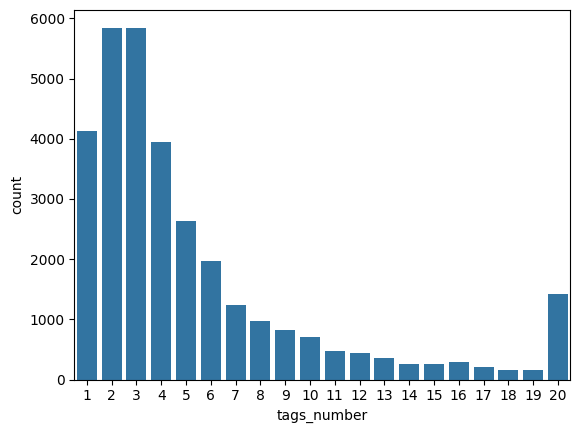

In [90]:
# Creating a new feature corresponding to 
# The counting of tags for each item
df_games['tags_number'] = df_games['tags'].map(len)

print('Maximum number of tags:', df_games['tags_number'].max())
print('Average number of tags:', round(df_games['tags_number'].mean(), 3))
print('Median:', df_games['tags_number'].median())
print('Std:', round(df_games['tags_number'].std()))

# Plotting distribution
sns.countplot(df_games, x='tags_number')

The same analisys can be applied for 'specs' column.

Maximum number of specifications: 21
Average number of specifications: 4.567
Median: 4.0
Std: 3


<Axes: xlabel='specs_number', ylabel='count'>

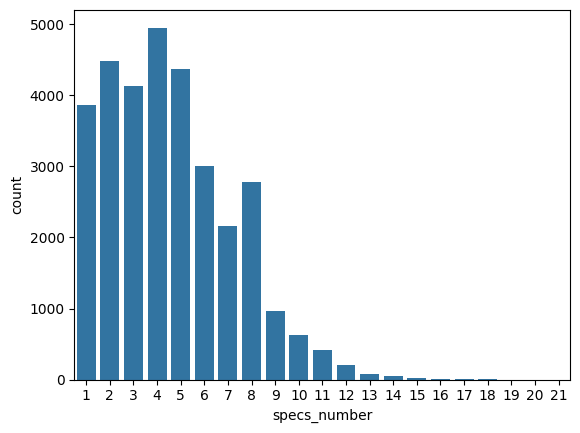

In [91]:
# Creating a new feature corresponding to 
# The counting of tags for each item
df_games['specs_number'] = df_games['specs'].map(len)

print('Maximum number of specifications:', df_games['specs_number'].max())
print('Average number of specifications:', round(df_games['specs_number'].mean(), 3))
print('Median:', df_games['specs_number'].median())
print('Std:', round(df_games['specs_number'].std()))

# Plotting distribution
sns.countplot(df_games, x='specs_number')

Both distributions for 'tags' and 'specs' are right skewed. There is plenty of items with a lot of tags (more than 10) and more than a thousand with 20 tags. 'specs' distribution looks more normal, although it presents positive skewness.

Something similar can be done for prices, let's see.

- Some preprocessing is needed because there are some 'Free to play' labels.

In [92]:
# Some preprocessing is needed
# 
df_games['price']

0                4.99
1        Free To Play
2        Free to Play
3                0.99
4                2.99
             ...     
32128            1.99
32129            4.99
32130            1.99
32131            4.99
32132            4.99
Name: price, Length: 32133, dtype: object

## **Recommender System** Using **Cosine Similarity**